Previous step before this analysis was `test_catalogs.ipynb`

# Imports

In [32]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import FoFCatalogMatching
import pycocotools.mask as mask_util
from multiprocessing import Pool
from functools import partial
# for unrec blend
from astropy.coordinates import search_around_sky, SkyCoord
import astropy.units as u
from astropy.table import Table
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm

# Data Loading and Truth Mag Limit

In [3]:
# same for all SNR levels
def truth_catalog_cut(baseline_mag_5sigma_10yr, years, baseline_snr=5, target_snr=5):
    """
    Calculate truth catalog magnitude cut at Rubin's nominal 5sigma depth adjusted 
    for the specified number of observation years.
    
    This cut is intended to be used consistently for defining the faint 
    limit of the truth sample for analysis (e.g., completeness), 
    including FOF matching.
    
    Parameters:
    baseline_mag_5sigma_10yr (float): 10-year 5σ depth (e.g., 26.8 for i-band)
    years (float): Analysis time baseline in years
    
    Returns:
    float: Magnitude cut for truth catalog
    """
    time_factor = np.sqrt(10 / years) # represents (sqrt(N_obs_10yr) / sqrt(N_obs_years))
    # delta_mag = 2.5 * log10(SNR_ratio)
    # SNR_ratio corresponds to 1 / time_factor for reaching the *same* SNR
    m_cut = baseline_mag_5sigma_10yr - 2.5 * np.log10(time_factor)
    # adjust for change in SNR threshold
    snr_ratio = baseline_snr / target_snr
    final_mcut = m_cut + 2.5 * np.log10(snr_ratio)
    return final_mcut

# for all SNR levels
baseline_mag_5sigma_10yr_i = 26.8  # From Rubin key numbers
years = 5
truth_mag_limit = truth_catalog_cut(baseline_mag_5sigma_10yr_i, years)
print(f"Truth catalog cut: mag_i <= {truth_mag_limit}")  # 26.42

Truth catalog cut: mag_i <= 26.423712505420024


In [4]:
# matched_lsst_det = pd.read_json('/u/yse2/lsst_runs/lsst5_30k_4h200_bs192_ep50/matched_lsst_det.json', orient='records')
# matched_dd_det = pd.read_json('/u/yse2/lsst_runs/lsst5_30k_4h200_bs192_ep50/matched_dd_det.json', orient='records')
lsst_truth_cat = pd.read_json('/u/yse2/lsst_runs/lsst5_30k_4h200_bs192_ep50/test_truth_maglim_cat.json', orient='records')
matched_lsst_truth_det = pd.read_json('/u/yse2/lsst_runs/lsst5_30k_4h200_bs192_ep50/matched_lsst_truth_det.json', orient='records')
matched_lsst_truth_dd = pd.read_json('/u/yse2/lsst_runs/lsst5_30k_4h200_bs192_ep50/matched_lsst_truth_dd.json', orient='records')

In [5]:
with open('/u/yse2/lsst_runs/lsst5_30k_4h200_bs192_ep50/pred_s0.45_n0.3.json', 'r') as f:
    dd_det = json.load(f)
dd_det_cat = pd.DataFrame(dd_det)
lsst_det_cat = pd.read_json('/u/yse2/lsst_runs/lsst5_30k_4h200_bs192_ep50/test_det_cat.json')

In [6]:
mag_bins = np.arange(16, truth_mag_limit, 0.5)

# Detection Completeness

In [ ]:
def plot_comp(mag_centers, comp, truth_cat, mag_bins, overall_comp,
              errors_lower=None, errors_upper=None,
              show_errors=True, error_style='bars',
              show_distribution=True, mag_col='mag_i',
              title='Detection Completeness',
              save_path=None):
    """
    Plot detection completeness w/ optional error bars/bands and mag distribution.
    
    Parameters:
    -----------
    mag_centers : array
        Magnitude bin centers
    comp : array
        Completeness values
    truth_cat : DataFrame
        Ground truth catalog for distribution
    mag_bins : array
        Magnitude bin edges
    overall_comp : float
        Overall completeness value
    errors_lower : array or None
        Lower error bounds
    errors_upper : array or None
        Upper error bounds
    show_errors : bool
        Whether to show error bars/bands
    error_style : str
        'bars' for error bars, 'bands' for shaded bands
    show_distribution : bool
        Whether to show magnitude distribution
    mag_col : str
        Magnitude column name
    title : str
        Plot title
    save_path : str or None
        Path to save figure
    """
    fig, ax1 = plt.subplots(figsize=(10, 6))    
    valid = ~np.isnan(comp)
    ax1.plot(mag_centers[valid], comp[valid], 'o-', color='blue', 
             linewidth=2, markersize=6, label='DeepDISC')
    if show_errors and errors_lower is not None and errors_upper is not None:
        if error_style == 'bars':
            yerr_lower = comp - errors_lower
            yerr_upper = errors_upper - comp
            yerr = np.array([yerr_lower[valid], yerr_upper[valid]])
            ax1.errorbar(mag_centers[valid], comp[valid], 
                        yerr=yerr, fmt='none', color='blue', 
                        capsize=3, alpha=0.5)
        elif error_style == 'bands':
            ax1.fill_between(mag_centers[valid], errors_lower[valid], 
                           errors_upper[valid], alpha=0.3, color='blue',
                           label='95% CI')
    
    ax1.set_xlabel('mag i', fontsize=12)
    ax1.set_ylabel('Detection Completeness', fontsize=12)
    ax1.tick_params(axis='y')
    ax1.set_ylim(-0.05, 1.05)
    ax1.grid(True, alpha=0.3)
    ax1.set_title(title, fontsize=14)
    if show_distribution:
        ax2 = ax1.twinx()
        mags = truth_cat[mag_col].values
        mags_clean = mags[np.isfinite(mags)]
        counts, bins, patches = ax2.hist(mags_clean, bins=mag_bins, 
                                        color='gray', alpha=0.2, 
                                        edgecolor='gray', linewidth=0.5)
        
        ax2.set_ylabel('Number of Ground Truth Objects', fontsize=12, color='gray')
        ax2.set_yscale('log')
        ax2.tick_params(axis='y', labelcolor='gray')
        ax2.set_ylim(1, np.max(counts) * 2)
    ax1.axhline(y=0.8, color='red', linestyle='--', alpha=0.5, linewidth=1, 
                label='80% Completeness')
    ax1.legend(loc='lower left')    
    textstr = f'Overall: {overall_comp:.1%}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax1.text(0.95, 0.95, textstr, transform=ax1.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='right', bbox=props)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')

def comp_by_mag(truth_cat, detected_mask, mag_col='mag_i',
                mag_bins=None, min_per_bin=10):
    """
    Calculate detection completeness as a function of mag.
    
    Parameters:
    -----------
    truth_cat : DataFrame
        Ground truth catalog
    detected_mask : boolean array
        Detection flag for each truth object
    mag_col : str
        Name of magnitude column to use
    mag_bins : array-like or None
        Magnitude bin edges. If None, auto-generate
    min_per_bin : int
        Minimum objects per bin for valid completeness
    
    Returns:
    --------
    mag_centers : array
        Center of each magnitude bin
    comp : array
        Detection completeness fraction for each bin
    counts : array
        Total number of truth objects in each bin
    detected_counts : array
        Number of detected truth objects in each bin
    """
    mags = truth_cat[mag_col].values
    if mag_bins is None:
        mag_bins = np.arange(18, 28.5, 0.5)
    mag_centers = (mag_bins[:-1] + mag_bins[1:]) / 2
    comps = []
    counts = []
    detected_counts = []
    for i in range(len(mag_bins) - 1):
        in_bin = (mags >= mag_bins[i]) & (mags < mag_bins[i+1])
        n_total = np.sum(in_bin)
        n_detected = np.sum(in_bin & detected_mask)
        if n_total >= min_per_bin:
            comp = n_detected / n_total
        else:
            comp = np.nan
        comps.append(comp)
        counts.append(n_total)
        detected_counts.append(n_detected)
    return mag_centers, np.array(comps), np.array(counts), np.array(detected_counts)

def bootstrap_comp(truth_cat, detected_mask, n_bootstrap=100,
                   mag_col='mag_i', mag_bins=None, seed=42):
    """
    Calculates bootstrap confidence intervals by resampling the matching results
    """
    np.random.seed(seed)
    n_truth = len(truth_cat)
    if mag_bins is None:
        mag_bins = np.arange(18, 28.5, 0.5)
    overall_samples = []
    binned_samples = []
    for i in range(n_bootstrap):
        if i % 100 == 0:
            print(f"Bootstrap sample {i}/{n_bootstrap}")
        # resample INDICES of the OG catalog
        idx = np.random.choice(n_truth, n_truth, replace=True)
        # creating bootstrap sample from the OG results using these indices
        truth_boot_cat = truth_cat.iloc[idx].reset_index(drop=True)
        detected_boot_mask = detected_mask[idx]
        # overall completeness for this sample
        overall_comp = np.sum(detected_boot_mask) / len(detected_boot_mask)
        overall_samples.append(overall_comp)
        # binned comp on the resampled results
        _, comp_boot, _, _ = comp_by_mag(
            truth_boot_cat, detected_boot_mask,
            mag_col=mag_col, mag_bins=mag_bins
        )
        binned_samples.append(comp_boot)
    return np.array(overall_samples), np.array(binned_samples)

def run_comp_analysis(truth_cat, matched_truth, 
                      mag_col='mag_i',
                      mag_bins=None,
                      n_bootstrap=100,
                      show_errors=True,
                      error_style='bands',
                      show_distribution=True,
                      confidence_level=0.95):
    """
    Run completeness analysis.
    Parameters:
    -----------
    truth_cat : DataFrame
        Full ground truth catalog
    matched_truth : DataFrame
        Matched truth objects (from match_with_truth function)
    """
    print("Calculating detection completeness...")
    # boolean mask: True if truth obj was detected
    # matched_truth has indices from truth_cat, so we can use them directly
    detected_mask = truth_cat.index.isin(matched_truth.index)
    n_detected = np.sum(detected_mask)
    n_total = len(truth_cat)
    overall_completeness = n_detected / n_total
    print(f"Overall detection completeness: {overall_completeness:.1%}")
    print(f"  Detected: {n_detected} / {n_total} objects")
    if mag_bins is None:
        mag_bins = np.arange(18, 28.5, 0.5)
        
    mag_centers, comps, counts, detected_counts = comp_by_mag(
        truth_cat, detected_mask, mag_col, mag_bins
    )
    
    print("\n------Completeness by magnitude--------")
    for i, (mc, comp, n, nd) in enumerate(zip(mag_centers, comps, counts, detected_counts)):
        if not np.isnan(comp):
            print(f"  {mag_bins[i]:.1f}-{mag_bins[i+1]:.1f}: "
                  f"{nd:4d}/{n:4d} = {comp:.1%}")
    errors_lower = None
    errors_upper = None
    overall_ci = None

    if show_errors and n_bootstrap > 0:
        print(f"\nRunning bootstrap with {n_bootstrap} samples...")
        overall_samples, binned_samples = bootstrap_comp(
            truth_cat, detected_mask, n_bootstrap,
            mag_col, mag_bins
        )
        alpha = 1 - confidence_level
        lower_percentile = (alpha/2) * 100
        upper_percentile = (1 - alpha/2) * 100
        overall_ci = np.percentile(overall_samples, [lower_percentile, upper_percentile])
        print(f"Overall completeness: {overall_completeness:.1%} "
              f"({overall_ci[0]:.1%}, {overall_ci[1]:.1%})")
        errors_lower = np.nanpercentile(binned_samples, lower_percentile, axis=0)
        errors_upper = np.nanpercentile(binned_samples, upper_percentile, axis=0)
    
    plot_comp(mag_centers, comps, truth_cat, mag_bins, overall_completeness,
              errors_lower, errors_upper,
              show_errors=show_errors and n_bootstrap > 0,
              error_style=error_style,
              show_distribution=show_distribution,
              mag_col=mag_col)
    
    results = {
        'overall_completeness': overall_completeness,
        'overall_ci': overall_ci,
        'mag_centers': mag_centers,
        'completeness': comps,
        'counts': counts,
        'detected_counts': detected_counts,
        'errors_lower': errors_lower,
        'errors_upper': errors_upper,
        'detected_mask': detected_mask
    }
    return results

In [ ]:
def plot_comp_comparison(results_list, labels, truth_cat, mag_bins,
                        show_errors=True, error_style='bands',
                        show_distribution=True, mag_col='mag_i',
                        title='Detection Completeness Comparison',
                        save_path=None,
                        colors=None):
    """
    Plot multiple completeness curves for comparison.
    
    Parameters:
    -----------
    results_list : list of dict
        List of results dictionaries from run_comp_analysis
    labels : list of str
        Labels for each method (e.g., ['DeepDISC', 'LSST Pipeline'])
    truth_cat : DataFrame
        Ground truth catalog for distribution
    mag_bins : array
        Magnitude bin edges
    show_errors : bool
        Whether to show error bars/bands
    error_style : str
        'bars' for error bars, 'bands' for shaded bands
    show_distribution : bool
        Whether to show magnitude distribution
    mag_col : str
        Magnitude column name
    title : str
        Plot title
    save_path : str or None
        Path to save figure
    colors : list of str or None
        Colors for each method. If None, uses default color cycle
    """
    if colors is None:
        colors = ['blue', 'red', 'green', 'orange', 'purple']
    fig, ax1 = plt.subplots(figsize=(12, 6))
    for i, (results, label, color) in enumerate(zip(results_list, labels, colors)):
        mag_centers = results['mag_centers']
        comp = results['completeness']
        valid = ~np.isnan(comp)
        # main completeness line
        ax1.plot(mag_centers[valid], comp[valid], 'o-', color=color, 
                linewidth=2, markersize=6, label=label, alpha=0.8)
        # Add errors if requested
        if show_errors and results['errors_lower'] is not None and results['errors_upper'] is not None:
            errors_lower = results['errors_lower']
            errors_upper = results['errors_upper']
            if error_style == 'bars':
                yerr_lower = comp - errors_lower
                yerr_upper = errors_upper - comp
                yerr = np.array([yerr_lower[valid], yerr_upper[valid]])
                ax1.errorbar(mag_centers[valid], comp[valid], 
                            yerr=yerr, fmt='none', color=color, 
                            capsize=3, alpha=0.3)
            elif error_style == 'bands':
                ax1.fill_between(mag_centers[valid], errors_lower[valid], 
                               errors_upper[valid], alpha=0.2, color=color)
    
    ax1.set_xlabel('mag i', fontsize=12)
    ax1.set_ylabel('Detection Completeness', fontsize=12)
    ax1.tick_params(axis='y')
    ax1.set_ylim(-0.05, 1.05)
    ax1.grid(True, alpha=0.3)
    ax1.set_title(title, fontsize=14)    
    if show_distribution:
        ax2 = ax1.twinx()
        mags = truth_cat[mag_col].values
        mags_clean = mags[np.isfinite(mags)]
        counts, bins, patches = ax2.hist(mags_clean, bins=mag_bins, 
                                        color='gray', alpha=0.15, 
                                        edgecolor='gray', linewidth=0.5)
        ax2.set_ylabel('Number of Ground Truth Objects', fontsize=12, color='gray')
        ax2.set_yscale('log')
        ax2.tick_params(axis='y', labelcolor='gray')
        ax2.set_ylim(1, np.max(counts) * 2)
    ax1.axhline(y=0.8, color='black', linestyle='--', alpha=0.3, linewidth=1, 
                label='80% Completeness')
    legend_labels = []
    for result, label in zip(results_list, labels):
        overall = result['overall_completeness']
        if result['overall_ci'] is not None:
            ci = result['overall_ci']
            legend_labels.append(f"{label}: {overall:.1%} ({ci[0]:.1%}, {ci[1]:.1%})")
        else:
            legend_labels.append(f"{label}: {overall:.1%}")
    handles, _ = ax1.get_legend_handles_labels() # custom legend
    ax1.legend(handles, legend_labels + ['80% Completeness'], 
              loc='lower left', fontsize=10)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')

DeepDISC Analysis
Calculating detection completeness...
Overall detection completeness: 76.9%
  Detected: 168846 / 219462 objects

------Completeness by magnitude--------
  16.0-16.3:   28/  40 = 70.0%
  16.3-16.6:   47/  58 = 81.0%
  16.6-16.9:   48/  61 = 78.7%
  16.9-17.2:   47/  64 = 73.4%
  17.2-17.5:   66/  87 = 75.9%
  17.5-17.8:   55/  69 = 79.7%
  17.8-18.1:   83/ 105 = 79.0%
  18.1-18.4:   82/ 108 = 75.9%
  18.4-18.7:  117/ 154 = 76.0%
  18.7-19.0:  144/ 189 = 76.2%
  19.0-19.3:  208/ 266 = 78.2%
  19.3-19.6:  270/ 325 = 83.1%
  19.6-19.9:  300/ 392 = 76.5%
  19.9-20.2:  341/ 446 = 76.5%
  20.2-20.5:  505/ 672 = 75.1%
  20.5-20.8:  635/ 838 = 75.8%
  20.8-21.1:  831/1081 = 76.9%
  21.1-21.4: 1028/1319 = 77.9%
  21.4-21.7: 1278/1666 = 76.7%
  21.7-22.0: 1604/2040 = 78.6%
  22.0-22.3: 1901/2484 = 76.5%
  22.3-22.6: 2391/3077 = 77.7%
  22.6-22.9: 2730/3589 = 76.1%
  22.9-23.2: 3456/4491 = 77.0%
  23.2-23.5: 4049/5265 = 76.9%
  23.5-23.8: 5277/6849 = 77.0%
  23.8-24.1: 6816/8886 

/u/yse2/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


Overall completeness: 85.3% (85.1%, 85.4%)


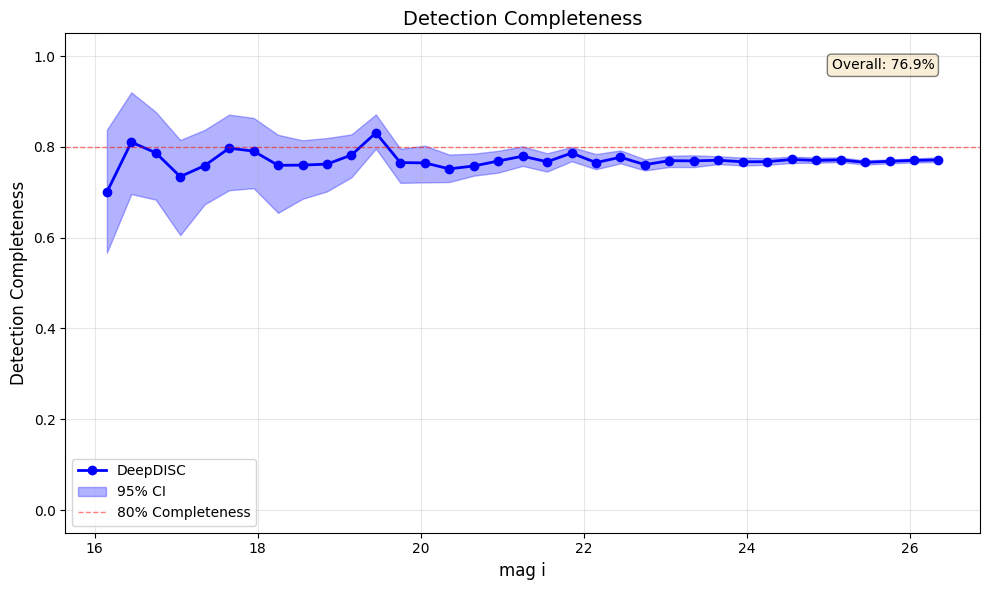

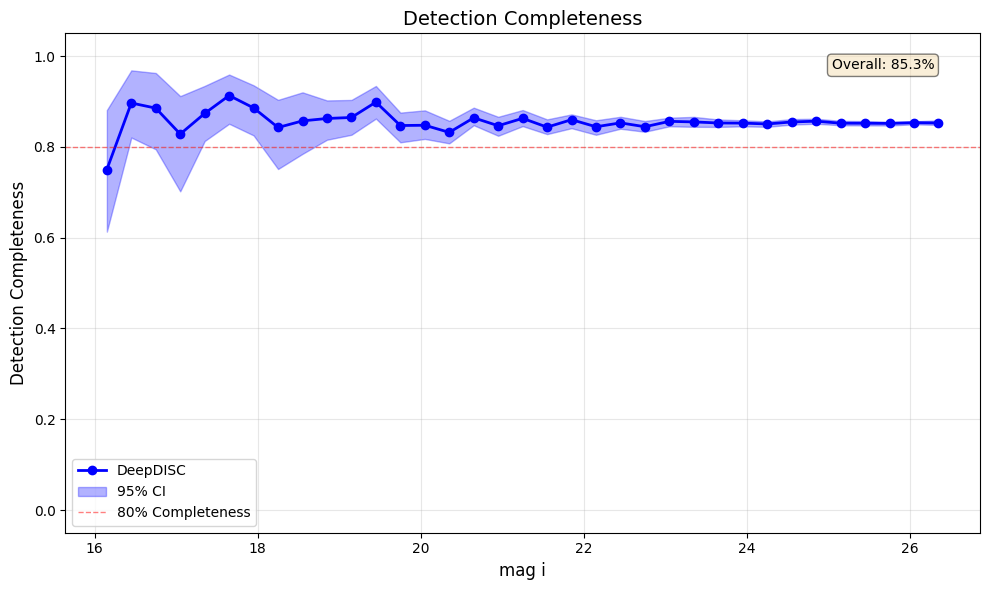

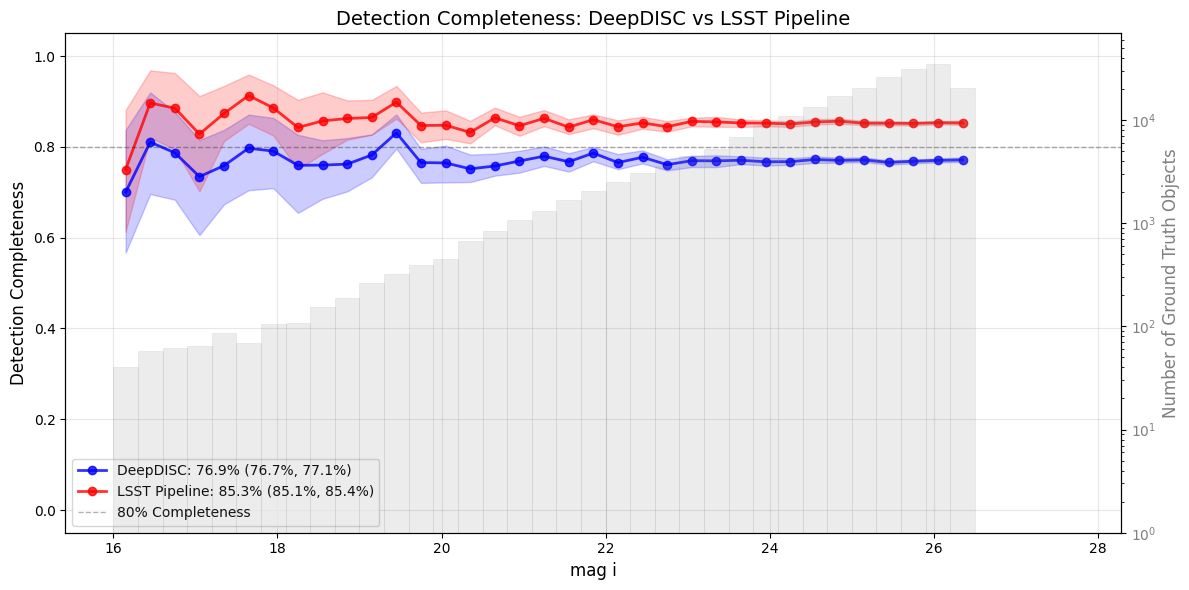

In [ ]:
print("DeepDISC Analysis")
results_dd = run_comp_analysis(
    truth_cat=lsst_truth_cat,
    matched_truth=matched_lsst_truth_dd,
    mag_col='mag_i',
    mag_bins=mag_bins,
    n_bootstrap=100,
    show_errors=True,
    error_style='bands',
    show_distribution=False,
    confidence_level=0.95
)

# TODO: ALLOW USER TO CHOOSE COLOR FOR TITLE AND COLOR OF `run_comp_analysis`
# print("LSST Pipeline Analysis")
# results_det = run_comp_analysis(
#     truth_cat=lsst_truth_cat,
#     matched_truth=matched_lsst_truth_det,
#     mag_col='mag_i',
#     mag_bins=mag_bins,
#     n_bootstrap=100,
#     show_errors=True,
#     error_style='bands',
#     show_distribution=False,
#     confidence_level=0.95
# )

plot_comp_comparison(
    results_list=[results_dd, results_det],
    labels=['DeepDISC', 'LSST Pipeline'],
    truth_cat=lsst_truth_cat,
    mag_bins=mag_bins,
    show_errors=True,
    error_style='bands',
    show_distribution=True,
    mag_col='mag_i',
    title='Detection Completeness: DeepDISC vs LSST Pipeline',
    save_path='/u/yse2/lsst_runs/lsst5_30k_4h200_bs192_ep50/dc_lsst_dd.png',
    colors=['blue', 'red']  # dd blue, LSST red
)

# FOF Plots

In [ ]:
# points within 1 arcsecs of each other are grouped together only if there's no more than 3 friends within 1 arcsec
# None following distance means points are grouped together without any constraint on number of friends
def find_matches(cat_a, cat_b, cat_a_name, cat_b_name, linking_length=1.0, max_friends=1):
    """
    Find matches between two catalogs using FOF algo.
    
    Parameters:
    -----------
    cat_a, cat_b : pd.DataFrame or astropy.table.Table
        The two catalogs to match. Should have 'ra' and 'dec' columns.
    cat_a_name, cat_b_name : str
        Names for the two catalogs.
    linking_length : float, optional
        The linking length in arcseconds. Default is 1.0.
    max_friends : int or None, optional
        Maximum num of friends allowed in a group. 
        Use None for no limit. Default is 1.
    
    Returns:
    --------
    astropy.table.Table
        Matched catalog with group IDs.
    """
    # FOF matching needs astropy tables so we convert to tables if they're dfs 
    if isinstance(cat_a, pd.DataFrame):
        cat_a_table = Table.from_pandas(cat_a[['ra', 'dec']])
    else:
        cat_a_table = cat_a
    if isinstance(cat_b, pd.DataFrame):
        cat_b_table = Table.from_pandas(cat_b[['ra', 'dec']])
    else:
        cat_b_table = cat_b
    linking_lengths = {linking_length: max_friends}
    return FoFCatalogMatching.match(
        {cat_a_name: cat_a_table, cat_b_name: cat_b_table},
        linking_lengths
    )

# Adapted from https://nbviewer.org/github/LSSTDESC/DC2-analysis/blob/rendered/tutorials/matching_fof.nbconvert.ipynb
# https://github.com/LSSTDESC/friendly/blob/FoF/notebooks/FoF_matching_example.ipynb
def autofit_text(ax, text, x, y):
    """Fits text within a cell in the FoF plot."""
    fontsize = 11
    bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="none", alpha=0)

    while fontsize > 1:
        t = ax.text(x, y, text, ha='center', va='center', fontsize=fontsize, 
                    color='white', bbox=bbox_props)
        r = ax.figure.canvas.get_renderer()
        bb = t.get_window_extent(renderer=r).transformed(ax.transData.inverted())
        # Check if text fits within the cell
        if bb.width < 1 and bb.height < 1:
            return
        t.remove()
        fontsize -= 1
    # If we got here, text is too large to fit at any readable size
    ax.text(x, y, '.', ha='center', va='center', fontsize=8, color='white')

def plot_matches(results, x_axis_name, xlabel, ylabel, title=None, save_path=None):
    """
    Plot FoF matching results as a 2D histogram.
    
    Parameters:
    -----------
    results : astropy.table.Table
        Results from find_matches()
    x_axis_name : str
        Name of catalog to use for x-axis (should match cat_a_name or cat_b_name)
    xlabel : str
        Label for x-axis
    ylabel : str
        Label for y-axis
    title : str, optional
        Plot title
    save_path : str, optional
        Path to save figure
    """
    # TODO: APPLY M_DELTA CUT as you do in UBF plot TO GET BETTER-LOOKING FOF plot
    # which rows are from x-axis catalog and which are from y-axis catalog
    cat_a_mask = results['catalog_key'] == x_axis_name
    cat_b_mask = ~cat_a_mask
    # counting number of objects in each group for each catalog
    n_groups = results['group_id'].max() + 1
    n_a = np.bincount(results['group_id'][cat_a_mask], minlength=n_groups)
    n_b = np.bincount(results['group_id'][cat_b_mask], minlength=n_groups)
    # 2D histogram of (n_a, n_b)
    n_max = max(n_a.max(), n_b.max()) + 1
    hist_2d = np.bincount(n_b * n_max + n_a, minlength=n_max*n_max).reshape(n_max, n_max)
    # total for %s
    total_groups = np.sum(hist_2d)
    plt.figure(figsize=(12, 10))
    plt.imshow(np.log10(hist_2d + 1), extent=(-0.5, n_max - 0.5, -0.5, n_max - 0.5), 
               origin='lower', cmap='Oranges')
    plt.xlabel(f'Number of {xlabel}', fontsize=12)
    plt.ylabel(f'Number of {ylabel}', fontsize=12)
    plt.colorbar(label=r'$\log(N_{\rm groups} \, + \, 1)$')
    if title:
        plt.title(title, fontsize=14)
    # text anns w/ count and %
    # TODO: I think % calculation is off. Re-verify
    ax = plt.gca()
    # regular w/o percentages
    # for i in range(n_max):
    #     for j in range(n_max):
    #         if hist_2d[i, j] > 0:
    #             text = str(int(hist_2d[i, j]))
    #             autofit_text(ax, text, j, i)
    for i in range(n_max):
        for j in range(n_max):
            if hist_2d[i, j] > 0:
                count = int(hist_2d[i, j])
                percent = 100 * count / total_groups
                # "count\n(percent%)"
                if percent >= 0.1:  # Only show percentage if >= 0.1%
                    text = f"{count}\n({percent:.1f}%)"
                else:
                    text = f"{count}\n(<0.1%)"
                autofit_text(ax, text, j, i)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    # print(f"\nFoF Matching Summary:")
    # print(f"  Total groups: {n_groups}")
    # print(f"  1-to-1 matches: {hist_2d[1, 1]}")
    # print(f"  1-to-many matches (x-axis): {np.sum(hist_2d[1, 2:])}")
    # print(f"  Many-to-1 matches (y-axis): {np.sum(hist_2d[2:, 1])}")
    # print(f"  Many-to-many matches: {np.sum(hist_2d[2:, 2:])}")
    # print(f"  Unmatched {xlabel}: {hist_2d[0, 1:]}")
    # print(f"  Unmatched {ylabel}: {hist_2d[1:, 0]}")
    print(f"\nFoF Matching Summary:")
    print(f"  Total groups: {total_groups}")
    if hist_2d[1, 1] > 0:
        print(f"  1-to-1 matches: {int(hist_2d[1, 1])} ({100*hist_2d[1, 1]/total_groups:.1f}%)")
    one_to_many = np.sum(hist_2d[1, 2:])
    if one_to_many > 0:
        print(f"  1-to-many matches (x-axis): {int(one_to_many)} ({100*one_to_many/total_groups:.1f}%)")
    many_to_one = np.sum(hist_2d[2:, 1])
    if many_to_one > 0:
        print(f"  Many-to-1 matches (y-axis): {int(many_to_one)} ({100*many_to_one/total_groups:.1f}%)")
    many_to_many = np.sum(hist_2d[2:, 2:])
    if many_to_many > 0:
        print(f"  Many-to-many matches: {int(many_to_many)} ({100*many_to_many/total_groups:.1f}%)")
    unmatched_x = np.sum(hist_2d[0, 1:])
    if unmatched_x > 0:
        print(f"  Unmatched {xlabel}: {int(unmatched_x)} ({100*unmatched_x/total_groups:.1f}%)")
    unmatched_y = np.sum(hist_2d[1:, 0])
    if unmatched_y > 0:
        print(f"  Unmatched {ylabel}: {int(unmatched_y)} ({100*unmatched_y/total_groups:.1f}%)")

Ok, now let's create a function that uses these functions to create the plots and summary.

In [ ]:
def run_fof_analysis(truth_cat, det_cat_dd, det_cat_pipeline, 
                     linking_length=1.0, max_friends=1,
                     save_dir='/u/yse2/lsst_runs/lsst5_30k_4h200_bs192_ep50'):
    """
    Run FoF matching analysis comparing DeepDISC and LSST Pipeline.
    
    Parameters:
    -----------
    truth_cat : pd.DataFrame
        Ground truth catalog
    det_cat_dd : pd.DataFrame
        DeepDISC detection catalog
    det_cat_pipeline : pd.DataFrame
        LSST Pipeline detection catalog
    linking_length : float
        Linking length in arcseconds
    max_friends : int or None
        Maximum friends per group
    save_dir : str
        Directory to save plots
    """
    # Match DeepDISC with truth using FOF
    print("Matching DeepDISC with truth catalog...")
    results_dd = find_matches(
        truth_cat, det_cat_dd,
        cat_a_name='truth',
        cat_b_name='deepdisc',
        linking_length=linking_length,
        max_friends=max_friends
    )
    plot_matches(
        results_dd,
        x_axis_name='truth',
        xlabel='Ground Truth Objects',
        ylabel='DeepDISC Detections',
        title=f'FoF Matching: DeepDISC (linking length={linking_length}")',
        save_path=f'{save_dir}/fof_deepdisc_vs_truth.png'
    )
    # Match LSST Pipeline with truth using FOF
    print("\nMatching LSST Pipeline with truth catalog...")
    results_pipeline = find_matches(
        truth_cat, det_cat_pipeline,
        cat_a_name='truth',
        cat_b_name='pipeline',
        linking_length=linking_length,
        max_friends=max_friends
    )
    plot_matches(
        results_pipeline,
        x_axis_name='truth',
        xlabel='Ground Truth Objects',
        ylabel='LSST Pipeline Detections',
        title=f'FoF Matching: LSST Pipeline (linking length={linking_length}")',
        save_path=f'{save_dir}/fof_pipeline_vs_truth.png'
    )
    # Match DeepDISC with LSST Pipeline
    print("\nMatching DeepDISC with LSST Pipeline...")
    results_dd_vs_pipeline = find_matches(
        det_cat_dd, det_cat_pipeline,
        cat_a_name='deepdisc',
        cat_b_name='pipeline',
        linking_length=linking_length,
        max_friends=max_friends
    )
    plot_matches(
        results_dd_vs_pipeline,
        x_axis_name='deepdisc',
        xlabel='DeepDISC Detections',
        ylabel='LSST Pipeline Detections',
        title=f'FoF Matching: DeepDISC vs LSST Pipeline (linking length={linking_length}")',
        save_path=f'{save_dir}/fof_deepdisc_vs_pipeline.png'
    )
    return results_dd, results_pipeline, results_dd_vs_pipeline

## Using All Detections from Both Pipeline and DeepDISC vs Truth Mag-limit 

Matching DeepDISC with truth catalog...

FoF Matching Summary:
  Total groups: 258458
  1-to-1 matches: 172034 (66.6%)
  1-to-many matches (x-axis): 10995 (4.3%)
  Many-to-1 matches (y-axis): 553 (0.2%)
  Many-to-many matches: 712 (0.3%)
  Unmatched Ground Truth Objects: 21890 (8.5%)
  Unmatched DeepDISC Detections: 52274 (20.2%)

Matching LSST Pipeline with truth catalog...

FoF Matching Summary:
  Total groups: 287436
  1-to-1 matches: 175896 (61.2%)
  1-to-many matches (x-axis): 11780 (4.1%)
  Many-to-1 matches (y-axis): 435 (0.2%)
  Many-to-many matches: 422 (0.1%)
  Unmatched Ground Truth Objects: 17522 (6.1%)
  Unmatched LSST Pipeline Detections: 81381 (28.3%)

Matching DeepDISC with LSST Pipeline...

FoF Matching Summary:
  Total groups: 293466
  1-to-1 matches: 210246 (71.6%)
  1-to-many matches (x-axis): 1016 (0.3%)
  Many-to-1 matches (y-axis): 1142 (0.4%)
  Many-to-many matches: 171 (0.1%)
  Unmatched DeepDISC Detections: 24016 (8.2%)
  Unmatched LSST Pipeline Detections: 56

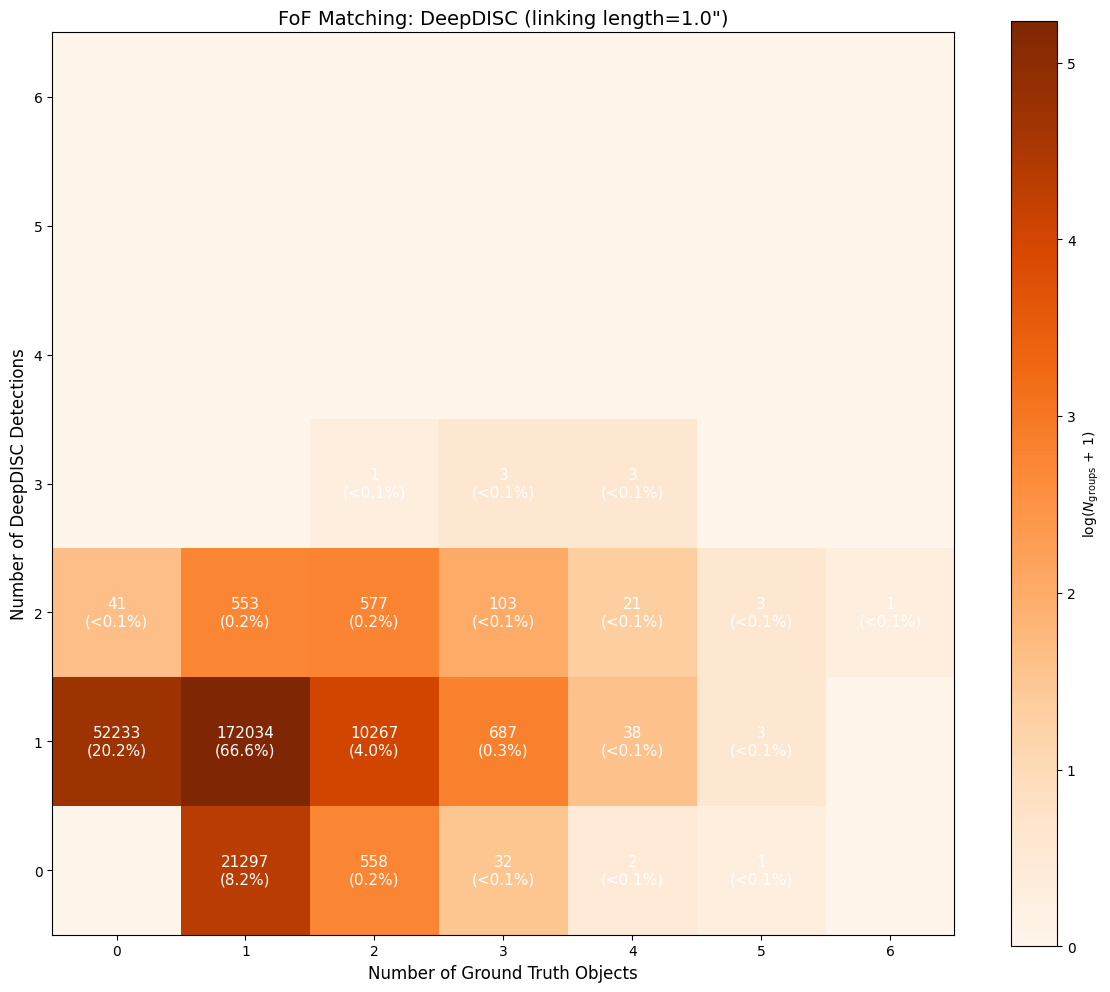

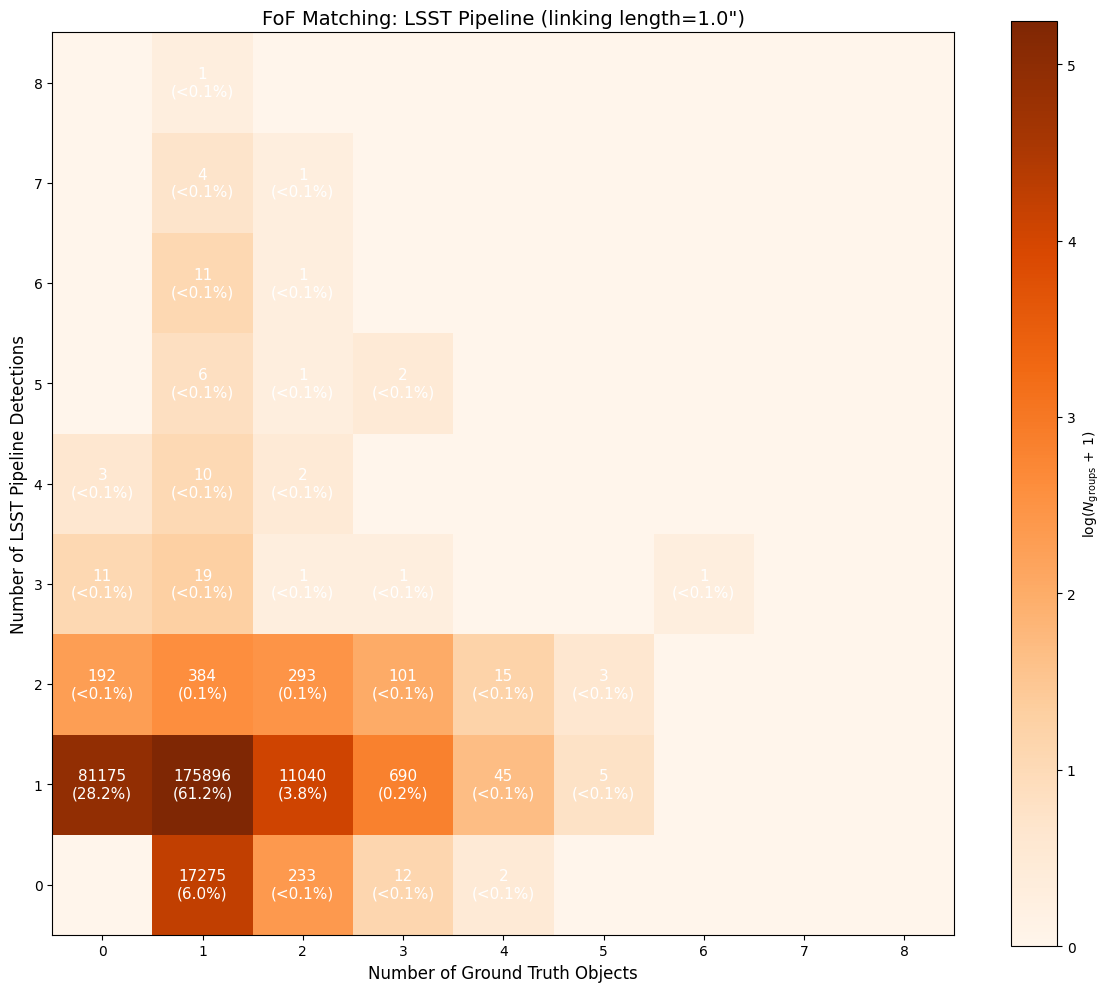

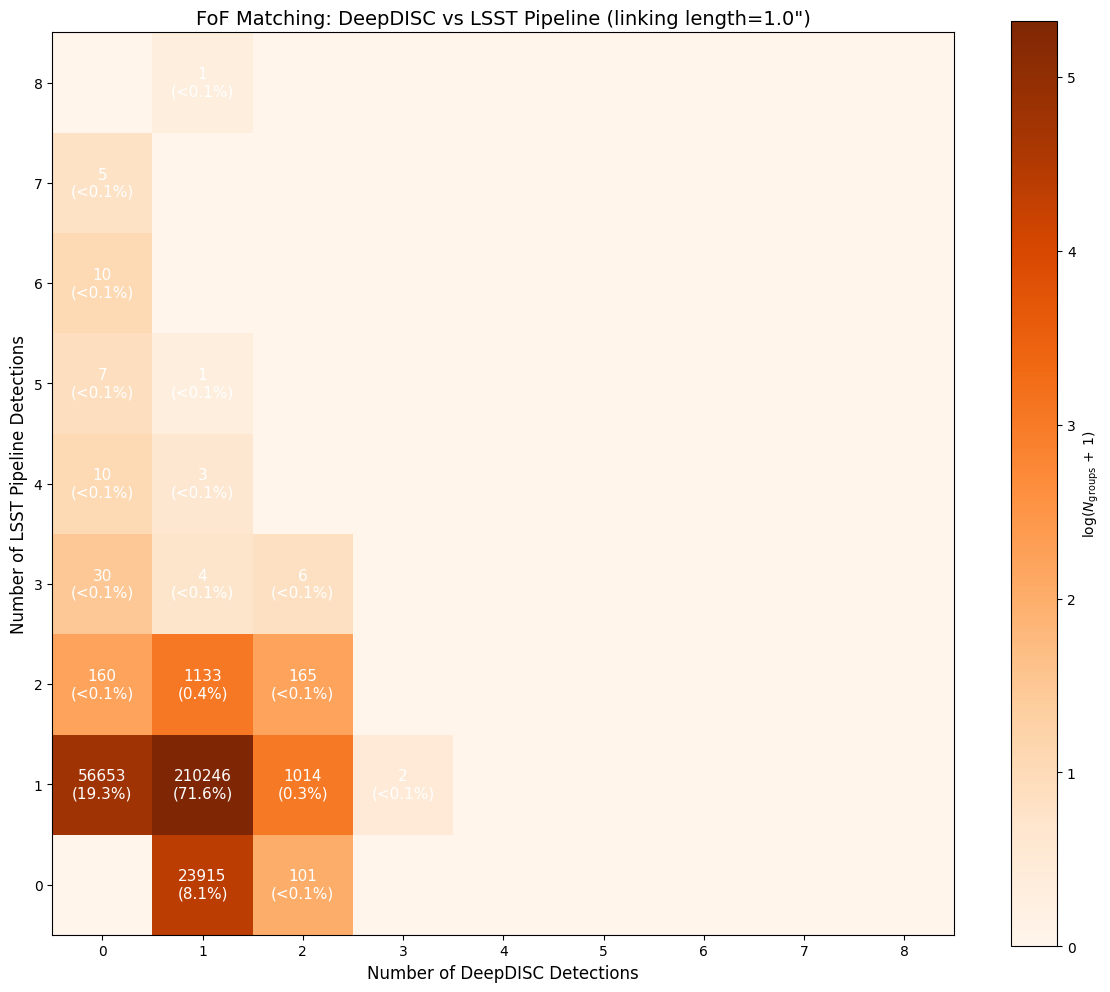

In [ ]:
results_dd, results_pipeline, results_comparison = run_fof_analysis(
    truth_cat=lsst_truth_cat,
    det_cat_dd=dd_det_cat,
    det_cat_pipeline=lsst_det_cat,
    linking_length=1.0,  # 1 arcsec
    max_friends=1        # only keep 1-to-1 matches
)

# Adding Magnitudes to Predictions

In [52]:
dd_det_cat

,id,ra,dec,class,file_name,bbox,score,rle_masks
0,0,53.666271,-41.221835,0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[42.89881134033203, 17.910329818725586, 65.676...",0.999335,"{'size': [150, 147], 'counts': 'Tm65_44M2N2O0O..."
1,1,53.666430,-41.216028,0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[41.83981704711914, 122.48597717285156, 64.390...",0.996112,"{'size': [150, 147], 'counts': 'hk64`45L2N101N..."
2,2,53.665345,-41.220572,0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[56.9978141784668, 41.76107406616211, 77.09436...",0.994498,"{'size': [150, 147], 'counts': 'UT96_42N2O1N10..."
3,3,53.662491,-41.215551,0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[97.68435668945312, 133.7820587158203, 115.389...",0.991342,"{'size': [150, 147], 'counts': '`R?4a43M10001O..."
4,4,53.663421,-41.217250,0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[83.06954193115234, 100.67486572265625, 104.23...",0.988882,"{'size': [150, 147], 'counts': 'Xk<3a45L2N101N..."
...,...,...,...,...,...,...,...,...
237876,237876,51.387144,-39.274313,0,/u/yse2/lsst_data/truth/51.46_-39.3/c193_51.46...,"[113.27100372314453, 129.22518920898438, 127.2...",0.630430,"{'size': [144, 147], 'counts': 'Zg`01Z45000MhK..."
237877,237877,51.385543,-39.274108,0,/u/yse2/lsst_data/truth/51.46_-39.3/c193_51.46...,"[138.3282470703125, 135.40371704101562, 146.81...",0.527989,"{'size': [144, 147], 'counts': 'mWd02]42OO2NdK'}"
237878,237878,51.391806,-39.275579,0,/u/yse2/lsst_data/truth/51.46_-39.3/c193_51.46...,"[46.38136291503906, 104.44239807128906, 64.198...",0.489888,"{'size': [144, 147], 'counts': 'oX76Y41O2O0000..."
237879,237879,51.390402,-39.280363,0,/u/yse2/lsst_data/truth/51.46_-39.3/c193_51.46...,"[67.48326873779297, 19.856773376464844, 82.159...",0.458763,"{'size': [144, 147], 'counts': 'hT:6Z41O0000O2..."


In [36]:
dd_det_cat.columns

Index(['id', 'ra', 'dec', 'class', 'file_name', 'bbox', 'score', 'rle_masks'], dtype='object')

We use the predicted RLE masks to calculate magnitude. For these coadds, the zeropoint is 27.

In [ ]:
def reconstruct_mask_from_rle(rle_dict):
    """
    Reconstructs a binary mask from a COCO RLE dictionary.
    """
    # 'counts' field was saved as a string for JSON format, so we encode it back to bytes
    rle_dict['counts'] = rle_dict['counts'].encode('utf-8')
    # decode RLE to a binary mask
    mask = mask_util.decode(rle_dict)
    return mask.astype(bool)

def process_det(row):
    """
    Process a single detection row to calculate mags for all bands.
    Args:
        row: A tuple of (index, Series) from iterrows() or dict from to_dict('records')
    Returns:
        Dictionary with id and calculated mags
    """
    try:
        # reconstruct mask from RLE
        rle_dict = row['rle_masks'].copy()
        # 'counts' field was saved as a string for JSON format, so we encode it back to bytes
        rle_dict['counts'] = rle_dict['counts'].encode('utf-8')
        # decode RLE to a binary mask
        mask = mask_util.decode(rle_dict).astype(bool)
        lsst_img = np.load(row['file_name'])
        band_names = ['u', 'g', 'r', 'i', 'z', 'y']
        mags = {'id': row['id']}
        for band_idx, band_name in enumerate(band_names):
            band_image = lsst_img[band_idx]
            instrumental_flux = np.sum(band_image[mask])
            # edge case where flux might be zero or negative
            if instrumental_flux <= 0:
                mags[f'mag_{band_name}'] = np.nan
            else:
                mag = 27 - 2.5 * np.log10(instrumental_flux)
                mags[f'mag_{band_name}'] = mag
        
        return mags
    except Exception as e:
        # NaN vals if processing fails
        return {
            'id': row['id'],
            **{f'mag_{band}': np.nan for band in ['u', 'g', 'r', 'i', 'z', 'y']}
        }


In [54]:
def calc_mags(dd_det_cat, n_processes=32):
    """
    Calculate mags for all detections using parallel processing
    Args:
        dd_det_cat: DataFrame with detection data
        n_processes: Number of parallel processes (default: 32)
    Returns:
        DataFrame with id and calculated magnitudes for all bands
    """
    # df to list of dicts for efficient multiprocessing
    rows = dd_det_cat.to_dict('records')
    # find optimal chunksize
    # For 237k rows and 32 CPUs: 237000 / (32 * 4) = ~1850
    chunksize = max(1, len(rows) // (n_processes * 4))
    print(f"Processing {len(rows)} detections with {n_processes} CPUs")
    print(f"Using chunksize: {chunksize}")
    with Pool(processes=n_processes) as pool:
        results = pool.map(process_det, rows, chunksize=chunksize)
    # results back to df
    mags_df = pd.DataFrame(results)
    return mags_df

In [55]:
mags_df = calc_mags(dd_det_cat, n_processes=32)

Processing 237881 detections with 32 CPUs
Using chunksize: 1858


## Distribution of DeepDISC Predicted Mags

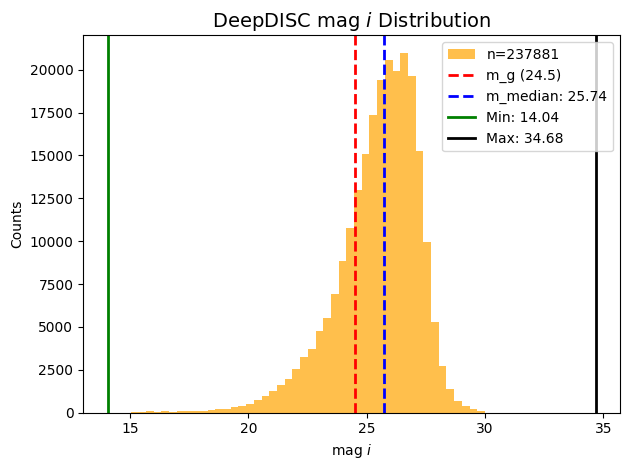

In [40]:
bins = np.linspace(mags_df['mag_i'].min(), 30, 50)
# fig, axs = plt.subplots(2, 1, figsize=(8, 12))
plt.title('DeepDISC mag $i$ Distribution', fontsize=14)
plt.hist(mags_df[mags_df['mag_i'] <= 30]['mag_i'], bins=bins, color='orange', alpha=0.7, 
           label=f'n={len(mags_df)}')
plt.axvline(24.5, color='red', linestyle='--', linewidth=2, label='m_g (24.5)')
median_mag = np.median(mags_df['mag_i'].dropna())
plt.axvline(median_mag, color='blue', linestyle='--', linewidth=2, label=f'm_median: {median_mag:.2f}')
plt.axvline(mags_df['mag_i'].min(), color='green', linestyle='-', 
              linewidth=2, label=f'Min: {mags_df["mag_i"].min():.2f}')
plt.axvline(mags_df['mag_i'].max(), color='black', linestyle='-', 
              linewidth=2, label=f'Max: {mags_df["mag_i"].max():.2f}')
plt.xlabel('mag $i$')
plt.ylabel('Counts')
plt.legend(frameon=True)
plt.tight_layout()

In [56]:
band_names = ['u', 'g', 'r', 'i', 'z', 'y']
for band_name in band_names:
    col_name = f'mag_{band_name}'
    valid_mags = mags_df[col_name].dropna()
    print(f"\n{band_name.upper()}-band:")
    print(f"  Valid mags: {len(valid_mags)}")
    if len(valid_mags) > 0:
        print(f"  Mean mag: {valid_mags.mean():.2f}")
        print(f"  Median mag: {valid_mags.median():.2f}")
        print(f"  Min mag: {valid_mags.min():.2f}")
        print(f"  Max mag: {valid_mags.max():.2f}")
    else:
        print(f"  No valid mags found")


U-band:
  Valid mags: 213753
  Mean mag: 26.64
  Median mag: 26.74
  Min mag: 13.76
  Max mag: 38.22

G-band:
  Valid mags: 237034
  Mean mag: 26.37
  Median mag: 26.58
  Min mag: 14.34
  Max mag: 37.76

R-band:
  Valid mags: 237875
  Mean mag: 25.85
  Median mag: 26.14
  Min mag: 14.19
  Max mag: 31.94

I-band:
  Valid mags: 237654
  Mean mag: 25.46
  Median mag: 25.74
  Min mag: 14.04
  Max mag: 34.68

Z-band:
  Valid mags: 229807
  Mean mag: 25.18
  Median mag: 25.40
  Min mag: 14.01
  Max mag: 37.32

Y-band:
  Valid mags: 222608
  Mean mag: 24.97
  Median mag: 25.18
  Min mag: 13.29
  Max mag: 37.93


In [57]:
# merging back into initial dataframe
dd_det_cat = dd_det_cat.merge(mags_df, on='id', how='left')
dd_det_cat

,id,ra,dec,class,file_name,bbox,score,rle_masks,mag_u,mag_g,mag_r,mag_i,mag_z,mag_y
0,0,53.666271,-41.221835,0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[42.89881134033203, 17.910329818725586, 65.676...",0.999335,"{'size': [150, 147], 'counts': 'Tm65_44M2N2O0O...",24.178501,24.361794,24.417967,24.268442,24.298439,23.601818
1,1,53.666430,-41.216028,0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[41.83981704711914, 122.48597717285156, 64.390...",0.996112,"{'size': [150, 147], 'counts': 'hk64`45L2N101N...",24.193335,24.437212,24.034464,23.551100,23.028345,22.912689
2,2,53.665345,-41.220572,0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[56.9978141784668, 41.76107406616211, 77.09436...",0.994498,"{'size': [150, 147], 'counts': 'UT96_42N2O1N10...",26.306913,26.051395,25.227131,24.238522,23.961708,23.851330
3,3,53.662491,-41.215551,0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[97.68435668945312, 133.7820587158203, 115.389...",0.991342,"{'size': [150, 147], 'counts': '`R?4a43M10001O...",26.619596,25.951719,25.406775,24.823856,24.747644,25.740545
4,4,53.663421,-41.217250,0,/u/yse2/lsst_data/truth/53.73_-41.1/c73_53.73_...,"[83.06954193115234, 100.67486572265625, 104.23...",0.988882,"{'size': [150, 147], 'counts': 'Xk<3a45L2N101N...",24.696024,24.835098,24.742519,24.630798,24.255783,23.613699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237876,237876,51.387144,-39.274313,0,/u/yse2/lsst_data/truth/51.46_-39.3/c193_51.46...,"[113.27100372314453, 129.22518920898438, 127.2...",0.630430,"{'size': [144, 147], 'counts': 'Zg`01Z45000MhK...",26.719328,27.458334,27.033850,27.349329,27.236979,25.773390
237877,237877,51.385543,-39.274108,0,/u/yse2/lsst_data/truth/51.46_-39.3/c193_51.46...,"[138.3282470703125, 135.40371704101562, 146.81...",0.527989,"{'size': [144, 147], 'counts': 'mWd02]42OO2NdK'}",NaN,28.596455,27.880468,27.188671,27.090696,26.914551
237878,237878,51.391806,-39.275579,0,/u/yse2/lsst_data/truth/51.46_-39.3/c193_51.46...,"[46.38136291503906, 104.44239807128906, 64.198...",0.489888,"{'size': [144, 147], 'counts': 'oX76Y41O2O0000...",25.030779,24.081413,23.338036,22.997311,22.811863,22.612520
237879,237879,51.390402,-39.280363,0,/u/yse2/lsst_data/truth/51.46_-39.3/c193_51.46...,"[67.48326873779297, 19.856773376464844, 82.159...",0.458763,"{'size': [144, 147], 'counts': 'hT:6Z41O0000O2...",25.410744,25.161430,24.625507,23.838020,23.649982,23.295933


In [58]:
dd_det_cat.to_json('/u/yse2/lsst_runs/lsst5_30k_4h200_bs192_ep50/pred_with_mag_s0.45_n0.3.json', orient='records')
print(f"Saved predictions with magnitudes to /u/yse2/lsst_runs/lsst5_30k_4h200_bs192_ep50/pred_with_mag_s0.45_n0.3.json")

Saved predictions with magnitudes to /u/yse2/lsst_runs/lsst5_30k_4h200_bs192_ep50/pred_with_mag_s0.45_n0.3.json


# Unrecognized Blend Fraction

Ideally, we want to use the results from the FOF plots here to prevent unnecessary recalculations, but for now, I'm going to be following the two-stage process similar to what I did for replicating the DP1 technote using DeepDISC.

To compare DeepDISC and the LSST Pipeline, we apply similar spatial matching logic used in the technote, but we will swap the `Space/HST` catalog for the LSST Ground Truth catalog since we actually have ground truth.

1) **Symmetric Neighbor Counting (Stage A)**:
For every detection in the catalog (DeepDISC or Pipeline), we calculate two numbers using a 2.0\" search radius. 
- N_det: How many detected objects are in this radius (including itself)? 
- N_truth: How many filtered ground truth objects are in this radius?
2) **Classifying Blends**:
Classify each detection based on counts:
- Unrecognized Blend: N_truth > N_det (More truth objects than detections)
- Recognized Blend/Pure: N_truth <= N_det
- Spurious: N_truth == 0 (Usually excluded from the blend fraction denominator)"
3) **Magnitude Difference Cut**:
This cut prevents a bright object (mag 20) from being classified a 'blend' just because a faint object (mag 26) is nearby ($N_{truth} > N_{det}). Without the cut, we'd get an artificially high blend fraction, since a lot of deep sky fields are crowded with faint objects that don't actually meaningfully impact the photometry of brighter sources. So, we restrict the definition of a blend to only include truth neighbors that are within a specific brightness range (e.g., 2.0 mags) of the main object. This filters out negligible background objects and focuses the metric on *significant* blends (cases where overlapping sources have comparable fluxes that would actually affect downstream tasks)

In [7]:
# load in the pred file with mags
dd_det_cat = pd.read_json('/u/yse2/lsst_runs/lsst5_30k_4h200_bs192_ep50/pred_with_mag_s0.45_n0.3.json', orient='records')

In [8]:
print(f"DeepDISC objects (incl. NAN mag_i's): {len(dd_det_cat)}")
print(f"LSST Pipeline objects (incl. NAN mag_i's): {len(lsst_det_cat)}")
print(f"Truth objects (incl. NAN mag_i's but after depth/mag cut): {len(lsst_truth_cat)}")
# drop NaNs in mag cols to avoid errors during binning/matching
dd_det_cat = dd_det_cat.dropna(subset=['mag_i']).reset_index(drop=True)
lsst_det_cat = lsst_det_cat.dropna(subset=['mag_i_cModel']).reset_index(drop=True)
lsst_truth_cat = lsst_truth_cat.dropna(subset=['mag_i']).reset_index(drop=True)
print(f"DeepDISC objects: {len(dd_det_cat)}")
print(f"LSST Pipeline objects: {len(lsst_det_cat)}")
print(f"Truth objects (after depth/mag cut): {len(lsst_truth_cat)}")

DeepDISC objects (incl. NAN mag_i's): 237881
LSST Pipeline objects (incl. NAN mag_i's): 271146
Truth objects (incl. NAN mag_i's but after depth/mag cut): 219462
DeepDISC objects: 237654
LSST Pipeline objects: 270034
Truth objects (after depth/mag cut): 219462


In [9]:
# standardize cols
dd_det_cat['chosen_mag'] = dd_det_cat['mag_i']
lsst_det_cat['chosen_mag'] = lsst_det_cat['mag_i_cModel']
lsst_truth_cat['chosen_mag'] = lsst_truth_cat['mag_i']

In [10]:
# dd_det_cat
# lsst_det_cat
lsst_truth_cat

,ra,dec,mag_i,class,obj_id,obj_truth_idx,chosen_mag
0,53.666375,-41.218364,26.182444,0,9501803150,9,26.182444
1,53.666449,-41.216024,23.855207,0,9502520267,13,23.855207
2,53.666394,-41.215661,24.306143,0,9502520268,14,24.306143
3,53.668981,-41.222707,25.905224,0,9502137039,18,25.905224
4,53.667297,-41.216503,24.676319,0,9502183784,19,24.676319
...,...,...,...,...,...,...,...
219457,51.388239,-39.275942,25.373577,0,8638094615,110,25.373577
219458,51.388639,-39.275176,26.393204,0,8638094616,111,26.393204
219459,51.390012,-39.279342,25.474951,0,8638642865,121,25.474951
219460,51.388997,-39.281391,25.149429,0,8641061146,130,25.149429


In [11]:
def analyze_unrec_blends(det_cat, truth_cat, 
                                search_radius=2.0, 
                                use_m_delta=False, 
                                m_delta=2.0):
    """
    Calculates N_det and N_truth for every detection to identify unrecognized blends
    Parameters:
        det_cat (pd.DataFrame): Det catalog (must have 'ra', 'dec', 'chosen_mag')
        truth_cat (pd.DataFrame): Truth catalog (must have 'ra', 'dec', 'chosen_mag')
        search_radius (float): Search radius in arcseconds (default 2.0)
        use_m_delta (bool): If True, applies mag difference logic
        m_delta (float): The mag window for counting truth neighbors
        
    Returns:
        dict: Contains boolean masks and count arrays.
    """
    c_det = SkyCoord(ra=det_cat['ra'].values*u.deg, dec=det_cat['dec'].values*u.deg)
    c_truth = SkyCoord(ra=truth_cat['ra'].values*u.deg, dec=truth_cat['dec'].values*u.deg)
    # --- Stage A: N_det (Ground-Ground equivalent from technote) ---
    # count how many dets are within radius of itself
    # search_around_sky includes the object itself if radius > 0
    idx_d1, idx_d2, _, _ = search_around_sky(c_det, c_det, seplimit=search_radius*u.arcsec)
    N_det = np.bincount(idx_d1, minlength=len(det_cat))
    # --- Stage B: N_truth (Ground-Truth equivalent from technote) ---
    idx_det_match, idx_truth_match, _, _ = search_around_sky(c_det, c_truth, seplimit=search_radius*u.arcsec)
    # --- Stage C: Filter N_truth by m_delta if flag true ---
    if not use_m_delta:
        # simple count of all truth objs within radius
        # THIS MIGHT NOT BE FULLY ACCURATE and GIVE ARTIFICALLY BOOSTED UBF
        N_truth_final = np.bincount(idx_det_match, minlength=len(det_cat))
    else:
        # Ok, for this filter, we need to count only truth objs that are "significant"
        # i.e., within m_delta of the brightest truth neighbor for that detection
        # let's make a tmp df of matches to use pandas groupby
        match_df = pd.DataFrame({
            'det_idx': idx_det_match,
            'truth_mag': truth_cat['chosen_mag'].values[idx_truth_match]
        })
        # mag of brightest truth neighbor for each detection
        brightest_mag = match_df.groupby('det_idx')['truth_mag'].min()
        # map brightest mag back to the match list
        match_df['brightest_mag'] = match_df['det_idx'].map(brightest_mag)
        # now we filter matches: keep only those within window that we set
        # (truth_mag <= brightest + m_delta)
        valid_matches = match_df[match_df['truth_mag'] <= (match_df['brightest_mag'] + m_delta)]
        # valid matches
        N_truth_final = np.bincount(valid_matches['det_idx'], minlength=len(det_cat))

    # --- Classification ---
    # unrec blend: Truth matches > Detected matches (multiple sources were detected as one)
    is_unrec = N_truth_final > N_det
    # spurious/split: Detected matches > Truth matches (usually excluded from denom using its mask)
    is_spurious = N_det > N_truth_final
    # Eligible: Denom for the fraction
    # Technote defines eligibility as objects that are NOT spurious
    # i.e., N_truth >= N_det. We also want at least one truth match to even talk about blending properly
    has_match = N_truth_final > 0
    eligible_mask = (~is_spurious) & has_match
    return {
        'is_unrec': is_unrec,
        'eligible_mask': eligible_mask,
        'N_det': N_det,
        'N_truth': N_truth_final
    }

In [12]:
RADIUS = 2.0 # arcsec
ENABLE_M_DELTA = False
M_DELTA = 2.0
print(f"Running matching (Radius={RADIUS}", f"m_delta={ENABLE_M_DELTA})...")
# for DeepDISC
print("Processing DeepDISC...")
dd_results = analyze_unrec_blends(dd_det_cat, lsst_truth_cat, 
                                         search_radius=RADIUS, 
                                         use_m_delta=ENABLE_M_DELTA, 
                                         m_delta=M_DELTA)
# for LSST Pipeline
print("Processing LSST Pipeline...")
lsst_results = analyze_unrec_blends(lsst_det_cat, lsst_truth_cat, 
                                           search_radius=RADIUS, 
                                           use_m_delta=ENABLE_M_DELTA, 
                                           m_delta=M_DELTA)

Running matching (Radius=2.0 m_delta=False)...
Processing DeepDISC...
Processing LSST Pipeline...


In [13]:
dd_results, lsst_results

({'is_unrec': array([False,  True, False, ..., False, False, False], shape=(237654,)),
  'eligible_mask': array([ True,  True,  True, ...,  True, False, False], shape=(237654,)),
  'N_det': array([1, 1, 1, ..., 2, 2, 1], shape=(237654,)),
  'N_truth': array([1, 2, 1, ..., 2, 1, 0], shape=(237654,))},
 {'is_unrec': array([False, False, False, ..., False, False, False], shape=(270034,)),
  'eligible_mask': array([ True, False,  True, ..., False, False, False], shape=(270034,)),
  'N_det': array([1, 1, 1, ..., 3, 3, 1], shape=(270034,)),
  'N_truth': array([1, 0, 1, ..., 1, 1, 0], shape=(270034,))})

In [14]:
def calc_fracs(det_cat, results, bins):
    mags = det_cat['chosen_mag'].values
    is_unrec = results['is_unrec']
    eligible = results['eligible_mask']
    centers = []
    fractions = []
    errors = []
    for i in range(len(bins)-1):
        low, high = bins[i], bins[i+1]
        # mask for this bin AND eligibility
        bin_mask = (mags >= low) & (mags < high) & eligible
        n_denom = np.sum(bin_mask)
        if n_denom > 10: # min count to plot
            n_num = np.sum(bin_mask & is_unrec)
            frac = n_num / n_denom
            # just using binomial error bars
            # TODO: Use boostrapping to get error bars instead
            err = np.sqrt(frac * (1 - frac) / n_denom)
            centers.append((low + high) / 2)
            fractions.append(frac)
            errors.append(err)
        else:
            centers.append((low + high) / 2)
            fractions.append(np.nan)
            errors.append(np.nan)
    # let's just do overall as well
    total_eligible = np.sum(eligible)
    total_unrec = np.sum(is_unrec & eligible)
    overall_frac = total_unrec / total_eligible if total_eligible > 0 else 0.0
    return np.array(centers), np.array(fractions), np.array(errors), overall_frac

--- Summary Stats ---
DeepDISC: 13.74%  (24451 / 177918)
LSST Pipeline: 12.71%  (22632 / 178034)
DeepDISC Overall Eligible: 177918
DeepDISC Overall Unrec Blends: 24451
LSST Pipeline Overall Eligible: 178034
LSST Pipeline Overall Unrec Blends: 22632

--- Fractions per Magnitude Bin ---
Mag Center   | DeepDISC Frac   | LSST Pipe Frac 
------------------------------------------------
16.25        | 0.1944          | 0.1781         
16.75        | 0.2059          | 0.2551         
17.25        | 0.2840          | 0.2519         
17.75        | 0.2190          | 0.2812         
18.25        | 0.2083          | 0.3000         
18.75        | 0.2217          | 0.3265         
19.25        | 0.2006          | 0.2994         
19.75        | 0.1966          | 0.2663         
20.25        | 0.2160          | 0.2998         
20.75        | 0.2336          | 0.2915         
21.25        | 0.2528          | 0.3178         
21.75        | 0.2561          | 0.3130         
22.25        | 0.2685       

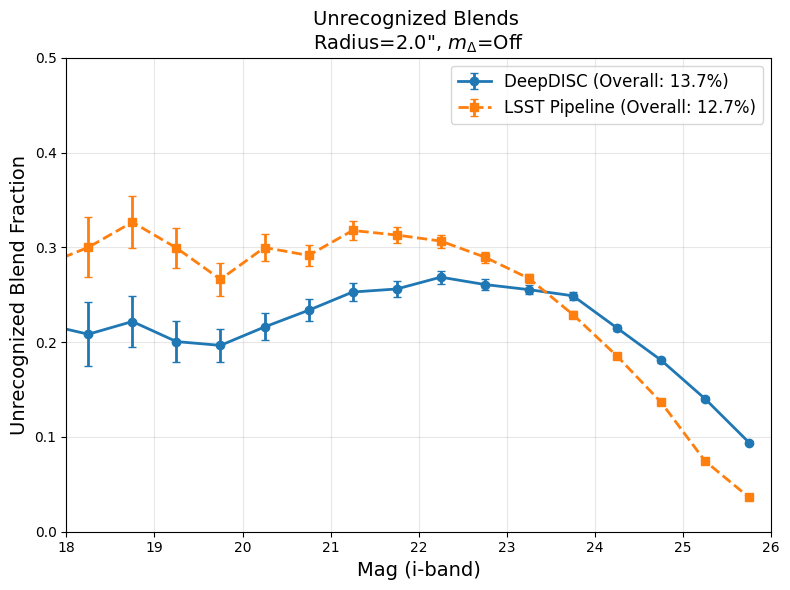

In [15]:
mag_bins = np.arange(16, truth_mag_limit, 0.5)
dd_x, dd_y, dd_err, dd_overall = calc_fracs(dd_det_cat, dd_results, mag_bins)
lsst_x, lsst_y, lsst_err, lsst_overall = calc_fracs(lsst_det_cat, lsst_results, mag_bins)
plt.figure(figsize=(8, 6))
# DeepDISC
plt.errorbar(dd_x, dd_y, yerr=dd_err, fmt='o-', capsize=3, 
             label=f'DeepDISC (Overall: {dd_overall:.1%})', color='tab:blue', linewidth=2)
# LSST Pipeline
plt.errorbar(lsst_x, lsst_y, yerr=lsst_err, fmt='s--', capsize=3, 
             label=f'LSST Pipeline (Overall: {lsst_overall:.1%})', color='tab:orange', linewidth=2)

plt.xlabel('Mag (i-band)', fontsize=14)
plt.ylabel('Unrecognized Blend Fraction', fontsize=14)
plt.title(f'Unrecognized Blends \nRadius={RADIUS}", $m_{{\\Delta}}$={M_DELTA if ENABLE_M_DELTA else "Off"}', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.ylim(0, 0.5)
plt.xlim(18, 26)
plt.tight_layout()
print("--- Summary Stats ---")
print(f"DeepDISC: {dd_overall:.2%}  ({np.sum(dd_results['is_unrec'] & dd_results['eligible_mask'])} / {np.sum(dd_results['eligible_mask'])})")
print(f"LSST Pipeline: {lsst_overall:.2%}  ({np.sum(lsst_results['is_unrec'] & lsst_results['eligible_mask'])} / {np.sum(lsst_results['eligible_mask'])})")
print(f"DeepDISC Overall Eligible: {np.sum(dd_results['eligible_mask'])}")
print(f"DeepDISC Overall Unrec Blends: {np.sum(dd_results['is_unrec'])}")
print(f"LSST Pipeline Overall Eligible: {np.sum(lsst_results['eligible_mask'])}")
print(f"LSST Pipeline Overall Unrec Blends: {np.sum(lsst_results['is_unrec'])}")
print("\n--- Fractions per Magnitude Bin ---")
# fancy way of formatting the strings to left-align the text within a field that is x characters wide
# < is left alignment and num is minimum field width
print(f"{'{:<12}'.format('Mag Center')} | {'{:<15}'.format('DeepDISC Frac')} | {'{:<15}'.format('LSST Pipe Frac')}")
print("-" * 48)
for mag, dd_frac, lsst_frac in zip(dd_x, dd_y, lsst_y):
    # Format fractions, handling NaNs (bins with insufficient data)
    dd_str = f"{dd_frac:.4f}" if not np.isnan(dd_frac) else "   --   "
    lsst_str = f"{lsst_frac:.4f}" if not np.isnan(lsst_frac) else "   --   "
    print(f"{mag:<12.2f} | {dd_str:<15} | {lsst_str:<15}")

In [16]:
RADIUS = 2.0 # arcsec
ENABLE_M_DELTA = True
M_DELTA = 2.0
print(f"Running matching (Radius={RADIUS}", f"m_delta={ENABLE_M_DELTA})...")
# for DeepDISC
print("Processing DeepDISC...")
dd_results = analyze_unrec_blends(dd_det_cat, lsst_truth_cat, 
                                         search_radius=RADIUS, 
                                         use_m_delta=ENABLE_M_DELTA, 
                                         m_delta=M_DELTA)
# for LSST Pipeline
print("Processing LSST Pipeline...")
lsst_results = analyze_unrec_blends(lsst_det_cat, lsst_truth_cat, 
                                           search_radius=RADIUS, 
                                           use_m_delta=ENABLE_M_DELTA, 
                                           m_delta=M_DELTA)

Running matching (Radius=2.0 m_delta=True)...
Processing DeepDISC...
Processing LSST Pipeline...


--- Summary Stats ---
DeepDISC: 10.70%  (18315 / 171204)
LSST Pipeline: 8.68%  (15205 / 175108)
DeepDISC Overall Eligible: 171204
DeepDISC Overall Unrec Blends: 18315
LSST Pipeline Overall Eligible: 175108
LSST Pipeline Overall Unrec Blends: 15205

--- Fractions per Magnitude Bin ---
Mag Center   | DeepDISC Frac   | LSST Pipe Frac 
------------------------------------------------
16.25        | 0.0000          | 0.0000         
16.75        | 0.0154          | 0.0102         
17.25        | 0.0000          | 0.0000         
17.75        | 0.0000          | 0.0000         
18.25        | 0.0078          | 0.0000         
18.75        | 0.0400          | 0.0068         
19.25        | 0.0261          | 0.0172         
19.75        | 0.0352          | 0.0250         
20.25        | 0.0572          | 0.0287         
20.75        | 0.0467          | 0.0377         
21.25        | 0.0653          | 0.0599         
21.75        | 0.0801          | 0.0637         
22.25        | 0.1116        

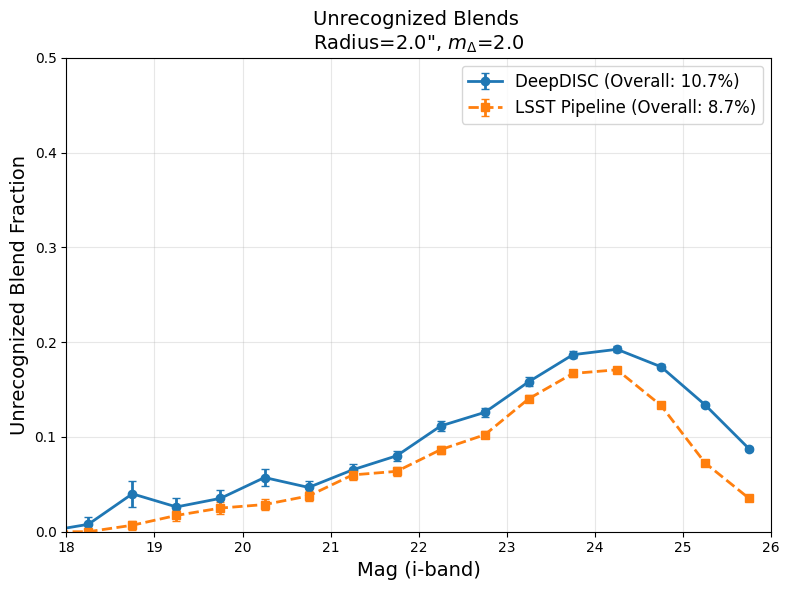

In [17]:
mag_bins = np.arange(16, truth_mag_limit, 0.5)
dd_x, dd_y, dd_err, dd_overall = calc_fracs(dd_det_cat, dd_results, mag_bins)
lsst_x, lsst_y, lsst_err, lsst_overall = calc_fracs(lsst_det_cat, lsst_results, mag_bins)
plt.figure(figsize=(8, 6))
# DeepDISC
plt.errorbar(dd_x, dd_y, yerr=dd_err, fmt='o-', capsize=3, 
             label=f'DeepDISC (Overall: {dd_overall:.1%})', color='tab:blue', linewidth=2)
# LSST Pipeline
plt.errorbar(lsst_x, lsst_y, yerr=lsst_err, fmt='s--', capsize=3, 
             label=f'LSST Pipeline (Overall: {lsst_overall:.1%})', color='tab:orange', linewidth=2)

plt.xlabel('Mag (i-band)', fontsize=14)
plt.ylabel('Unrecognized Blend Fraction', fontsize=14)
plt.title(f'Unrecognized Blends \nRadius={RADIUS}", $m_{{\\Delta}}$={M_DELTA if ENABLE_M_DELTA else "Off"}', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.ylim(0, 0.5)
plt.xlim(18, 26)
plt.tight_layout()
print("--- Summary Stats ---")
print(f"DeepDISC: {dd_overall:.2%}  ({np.sum(dd_results['is_unrec'] & dd_results['eligible_mask'])} / {np.sum(dd_results['eligible_mask'])})")
print(f"LSST Pipeline: {lsst_overall:.2%}  ({np.sum(lsst_results['is_unrec'] & lsst_results['eligible_mask'])} / {np.sum(lsst_results['eligible_mask'])})")
print(f"DeepDISC Overall Eligible: {np.sum(dd_results['eligible_mask'])}")
print(f"DeepDISC Overall Unrec Blends: {np.sum(dd_results['is_unrec'])}")
print(f"LSST Pipeline Overall Eligible: {np.sum(lsst_results['eligible_mask'])}")
print(f"LSST Pipeline Overall Unrec Blends: {np.sum(lsst_results['is_unrec'])}")
print("\n--- Fractions per Magnitude Bin ---")
# fancy way of formatting the strings to left-align the text within a field that is x characters wide
# < is left alignment and num is minimum field width
print(f"{'{:<12}'.format('Mag Center')} | {'{:<15}'.format('DeepDISC Frac')} | {'{:<15}'.format('LSST Pipe Frac')}")
print("-" * 48)
for mag, dd_frac, lsst_frac in zip(dd_x, dd_y, lsst_y):
    # Format fractions, handling NaNs (bins with insufficient data)
    dd_str = f"{dd_frac:.4f}" if not np.isnan(dd_frac) else "   --   "
    lsst_str = f"{lsst_frac:.4f}" if not np.isnan(lsst_frac) else "   --   "
    print(f"{mag:<12.2f} | {dd_str:<15} | {lsst_str:<15}")

## Comparison Plots with different matching radii and $m_{\Delta}$

In [53]:
def run_unrec_analysis_grid(dd_cat, lsst_cat, truth_cat, 
                            radius_list, m_delta_list, 
                            mag_bins, use_m_delta=True):
    results = []
    for radius in radius_list:
        for m_delta in m_delta_list:
            print(f"Calculating: R={radius}, m_delta={m_delta}...")
            dd_res = analyze_unrec_blends(dd_cat, truth_cat, radius, use_m_delta, m_delta)
            lsst_res = analyze_unrec_blends(lsst_cat, truth_cat, radius, use_m_delta, m_delta)
            # fractions
            dd_x, dd_y, dd_err, dd_ovr = calc_fracs(dd_cat, dd_res, mag_bins)
            lsst_x, lsst_y, lsst_err, lsst_ovr = calc_fracs(lsst_cat, lsst_res, mag_bins)
            results.append({
                'radius': radius,
                'm_delta': m_delta,
                'dd': {'x': dd_x, 'y': dd_y, 'err': dd_err, 'overall': dd_ovr},
                'lsst': {'x': lsst_x, 'y': lsst_y, 'err': lsst_err, 'overall': lsst_ovr}
            })
            print(f"DeepDISC: {dd_ovr:.2%} ({np.sum(dd_res['is_unrec'] & dd_res['eligible_mask'])} / {np.sum(dd_res['eligible_mask'])})")
            print(f"LSST Pipeline: {lsst_ovr:.2%} ({np.sum(lsst_res['is_unrec'] & lsst_res['eligible_mask'])} / {np.sum(lsst_res['eligible_mask'])})")
            print(f"DeepDISC Overall Unrec Blends: {np.sum(dd_res['is_unrec'])}")
            print(f"DeepDISC Overall Eligible: {np.sum(dd_res['eligible_mask'])}")
            print(f"LSST Pipeline Overall Unrec Blends: {np.sum(lsst_res['is_unrec'])}")
            print(f"LSST Pipeline Overall Eligible: {np.sum(lsst_res['eligible_mask'])}\n")
            # print("\n--- Fractions per Magnitude Bin ---")
            # # fancy way of formatting the strings to left-align the text within a field that is x characters wide
            # # < is left alignment and num is minimum field width
            # print(f"{'{:<12}'.format('Mag Center')} | {'{:<15}'.format('DeepDISC Frac')} | {'{:<15}'.format('LSST Pipe Frac')}")
            # print("-" * 48)
            # for mag, dd_frac, lsst_frac in zip(dd_x, dd_y, lsst_y):
            #     # Format fractions, handling NaNs (bins with insufficient data)
            #     dd_str = f"{dd_frac:.4f}" if not np.isnan(dd_frac) else "   --   "
            #     lsst_str = f"{lsst_frac:.4f}" if not np.isnan(lsst_frac) else "   --   "
            #     print(f"{mag:<12.2f} | {dd_str:<15} | {lsst_str:<15}")
    return results

def plot_comparison(results, title_suffix=None, use_m_delta=True):
    # ok before I tried dotted lines and it gets really messy and hard to understand
    # so let's use color gradients instead and also create a residual plot so we can actually understand the performance diff
    # top for data and bottom for residuals
    fig = plt.figure(figsize=(15, 12))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.05)
    ax_main = plt.subplot(gs[0])
    ax_ratio = plt.subplot(gs[1], sharex=ax_main)
    # generate colors form light to dark
    n_configs = len(results)
    blues = cm.Blues(np.linspace(0.5, 1.0, n_configs))
    oranges = cm.Oranges(np.linspace(0.5, 1.0, n_configs))
    for idx, res in enumerate(results):
        r, md = res['radius'], res['m_delta']
        label_suffix = f"R={r}" + (f", $m_\\Delta$={md}" if use_m_delta else "")
        # DeepDISC
        ax_main.errorbar(res['dd']['x'], res['dd']['y'], yerr=res['dd']['err'],
                         fmt='o-', color=blues[idx], label=f'DD ({label_suffix}): {res["dd"]["overall"]:.1%}',
                         capsize=3, alpha=0.8)
        
        # LSST
        ax_main.errorbar(res['lsst']['x'], res['lsst']['y'], yerr=res['lsst']['err'],
                         fmt='s--', color=oranges[idx], label=f'LSST ({label_suffix}): {res["lsst"]["overall"]:.1%}',
                         capsize=3, alpha=0.8)
        
        # DeepDISC - LSST
        diff = res['dd']['y'] - res['lsst']['y']
        # propagate err roughly: sqrt(err1^2 + err2^2)
        # TODO: MAKE THIS MORE ROBUST
        diff_err = np.sqrt(res['dd']['err']**2 + res['lsst']['err']**2)
        ax_ratio.errorbar(res['dd']['x'], diff, yerr=diff_err, 
                          fmt='o-', color='gray', alpha=0.5)
        ax_ratio.axhline(0, color='k', linestyle=':', linewidth=1)

    ax_main.set_ylabel('Unrecognized Blend Fraction', fontsize=14)
    ax_main.set_ylim(0, 0.5)
    ax_main.grid(True, alpha=0.3)
    ax_main.legend(loc='upper left', fontsize=10, frameon=True)
    plt.setp(ax_main.get_xticklabels(), visible=False) # let's just hide x-ticks on top plot as it looks cleaner
    ax_ratio.set_ylabel('DD - LSST', fontsize=12)
    ax_ratio.set_xlabel('Mag (i-band)', fontsize=14)
    ax_ratio.grid(True, alpha=0.3)
    ax_ratio.set_ylim(-0.1, 0.1)
    #  = f"R={r}" + (f", $m_\\Delta$={md}" if title_suffix else "")
    plt.suptitle(f'Unrecognized Blends: DeepDISC vs LSST Pipeline {title_suffix if title_suffix else " "}', fontsize=16, y=0.92)

In [54]:
mag_bins = np.arange(16, truth_mag_limit, 0.5)
results_rads = run_unrec_analysis_grid(dd_det_cat, lsst_det_cat, lsst_truth_cat,
                            radius_list=[0.5, 1.0, 2.0],
                            m_delta_list=[2.0],
                            mag_bins=mag_bins,
                            use_m_delta=True)

Calculating: R=0.5, m_delta=2.0...
DeepDISC: 1.77% (2981 / 168849)
LSST Pipeline: 2.12% (3971 / 186877)
DeepDISC Overall Unrec Blends: 2981
DeepDISC Overall Eligible: 168849
LSST Pipeline Overall Unrec Blends: 3971
LSST Pipeline Overall Eligible: 186877

Calculating: R=1.0, m_delta=2.0...
DeepDISC: 4.61% (8497 / 184270)
LSST Pipeline: 5.03% (9485 / 188418)
DeepDISC Overall Unrec Blends: 8497
DeepDISC Overall Eligible: 184270
LSST Pipeline Overall Unrec Blends: 9485
LSST Pipeline Overall Eligible: 188418

Calculating: R=2.0, m_delta=2.0...
DeepDISC: 10.70% (18315 / 171204)
LSST Pipeline: 8.68% (15205 / 175108)
DeepDISC Overall Unrec Blends: 18315
DeepDISC Overall Eligible: 171204
LSST Pipeline Overall Unrec Blends: 15205
LSST Pipeline Overall Eligible: 175108



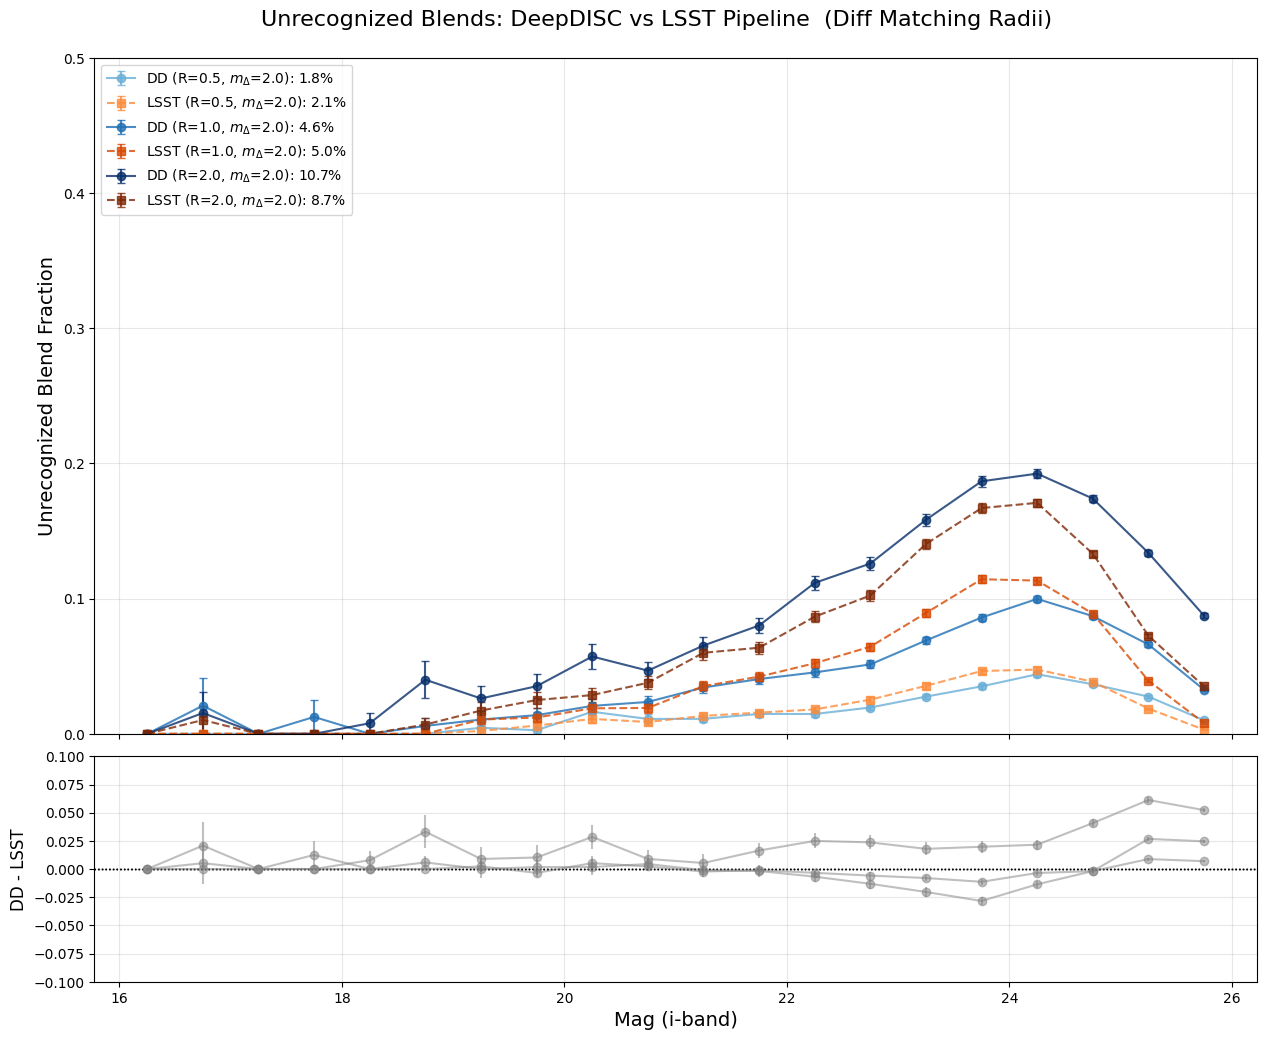

In [50]:
plot_comparison(results_rads, title_suffix=' (Diff Matching Radii)')

In [ ]:
results_m_deltas = run_unrec_analysis_grid(dd_det_cat, lsst_det_cat, lsst_truth_cat,
                            radius_list=[2.0],
                            m_delta_list=[1.0, 1.5, 2.0, 2.5],
                            mag_bins=mag_bins,
                            use_m_delta=True)

Calculating: R=2.0, m_delta=1.0...
DeepDISC: 7.01% (11572 / 165006)
LSST Pipeline: 5.27% (8859 / 167981)
DeepDISC Overall Unrec Blends: 11572
DeepDISC Overall Eligible: 165006
LSST Pipeline Overall Unrec Blends: 8859
LSST Pipeline Overall Eligible: 167981

Calculating: R=2.0, m_delta=1.5...
DeepDISC: 9.19% (15495 / 168652)
LSST Pipeline: 7.21% (12424 / 172336)
DeepDISC Overall Unrec Blends: 15495
DeepDISC Overall Eligible: 168652
LSST Pipeline Overall Unrec Blends: 12424
LSST Pipeline Overall Eligible: 172336

Calculating: R=2.0, m_delta=2.0...
DeepDISC: 10.70% (18315 / 171204)
LSST Pipeline: 8.68% (15205 / 175108)
DeepDISC Overall Unrec Blends: 18315
DeepDISC Overall Eligible: 171204
LSST Pipeline Overall Unrec Blends: 15205
LSST Pipeline Overall Eligible: 175108

Calculating: R=2.0, m_delta=2.5...
DeepDISC: 11.69% (20233 / 173054)
LSST Pipeline: 9.83% (17349 / 176543)
DeepDISC Overall Unrec Blends: 20233
DeepDISC Overall Eligible: 173054
LSST Pipeline Overall Unrec Blends: 17349
LSST

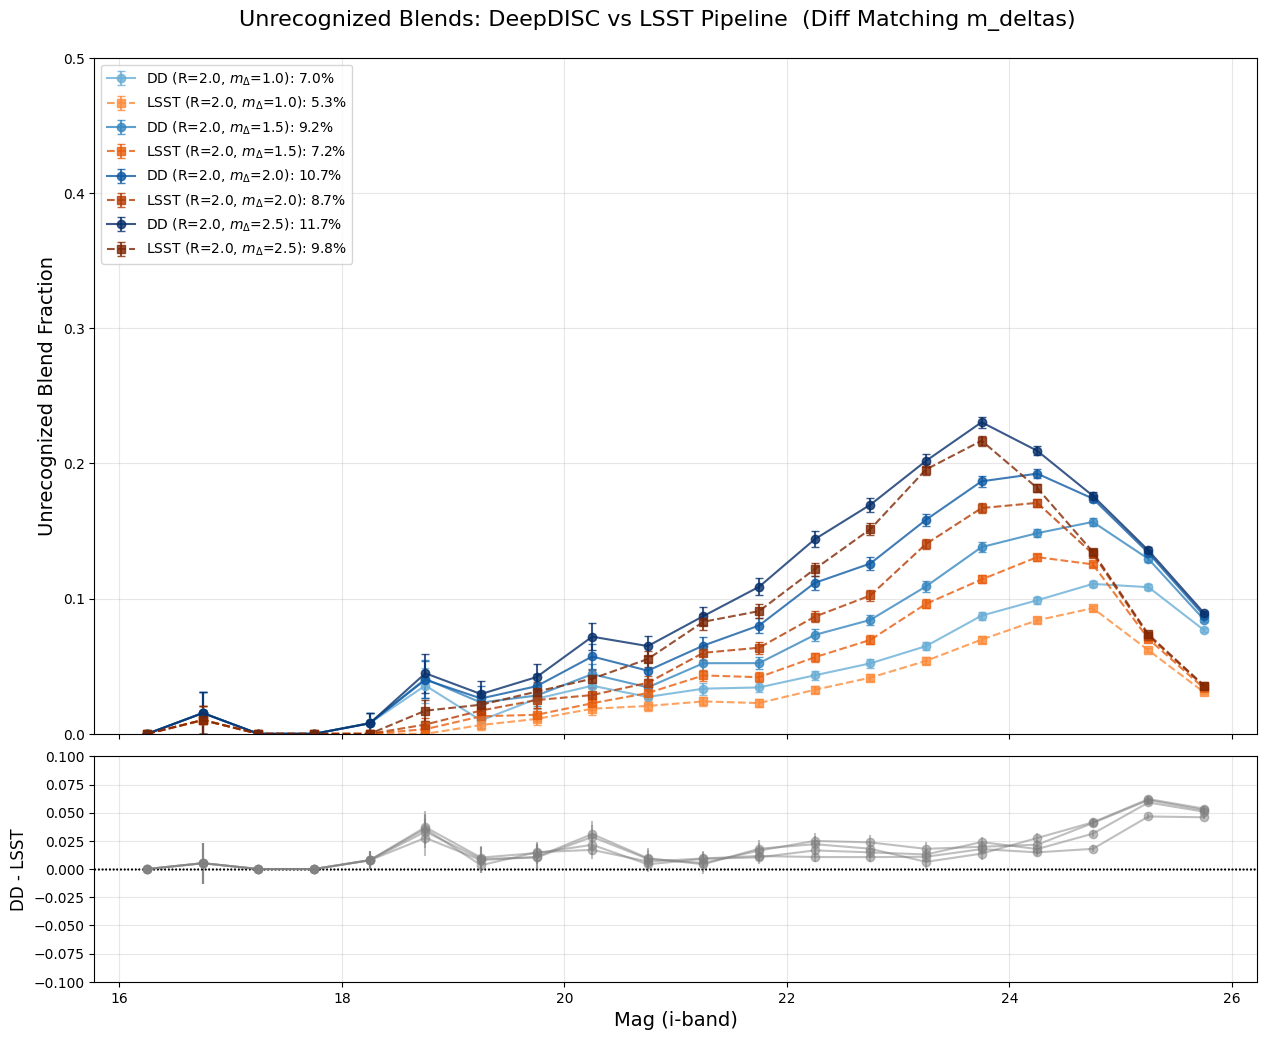

In [ ]:
plot_comparison(results_m_deltas, title_suffix=' (Diff m_deltas)')